# NYC Animal Services Data Analysis
This project analyzes 311 animal abuse complaint data in New York City. It explores trends over time, geographic distribution, and complaint types to uncover patterns that can inform public awareness, policymaking, and resource allocation.


In [49]:
!pip install notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap


Data was retrieved directly from NYC Open Data’s 311 API using the Socrata `sodapy` Python package.


In [51]:
# NYC Open Data API URL for 311 Animal Abuse data
url = "https://data.cityofnewyork.us/resource/epm3-jquf.csv?$limit=50000"

# Load data
df = pd.read_csv(url, parse_dates=["created_date"])

# Preview the data
df.head()



,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,43044838,2019-06-21 22:24:15,2019-06-21T23:21:00.000,NYPD,New York City Police Department,Animal Abuse,Neglected,Residential Building/House,11694.0,106-20 SHORE FRONT PARKWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.580723,-73.826713,POINT (-73.82671334939981 40.5807227850377)
1,43052398,2019-06-21 21:04:29,2019-06-21T23:25:06.000,NYPD,New York City Police Department,Animal Abuse,Neglected,Residential Building/House,11237.0,1460 GREENE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.701607,-73.916018,POINT (-73.91601812112371 40.701607096178385)
2,43042913,2019-06-21 19:34:09,2019-06-21T20:42:02.000,NYPD,New York City Police Department,Animal Abuse,Other (complaint details),Residential Building/House,11214.0,1768 80 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.611022,-73.999744,POINT (-73.99974428319928 40.611021546644466)
3,43040789,2019-06-21 16:37:39,2019-06-21T22:10:15.000,NYPD,New York City Police Department,Animal Abuse,Other (complaint details),Subway Station,10004.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.701505,-74.012551,POINT (-74.01255073642797 40.70150530149597)
4,43042912,2019-06-21 16:09:16,2019-06-21T20:29:48.000,NYPD,New York City Police Department,Animal Abuse,Other (complaint details),Residential Building/House,10458.0,4589 PARK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.857166,-73.893647,POINT (-73.89364743210966 40.857165778370025)


In [52]:
# How many rows and columns?
print("Shape:", df.shape)

# Check data types and missing values
df.info()


Shape: (50000, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      50000 non-null  int64         
 1   created_date                    50000 non-null  datetime64[ns]
 2   closed_date                     49972 non-null  object        
 3   agency                          50000 non-null  object        
 4   agency_name                     50000 non-null  object        
 5   complaint_type                  50000 non-null  object        
 6   descriptor                      50000 non-null  object        
 7   location_type                   50000 non-null  object        
 8   incident_zip                    49960 non-null  float64       
 9   incident_address                43555 non-null  object        
 10  street_name                     43555 non-null  obj

In [53]:
# Check missing values
df.isnull().sum()


unique_key                            0
created_date                          0
closed_date                          28
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
location_type                         0
incident_zip                         40
incident_address                   6445
street_name                        6445
cross_street_1                     6484
cross_street_2                     6549
intersection_street_1             43520
intersection_street_2             43555
address_type                         39
city                                 39
landmark                          50000
facility_type                        34
status                                0
due_date                              0
resolution_description                0
resolution_action_updated_date       26
community_board                       0
borough                               0


We removed rows with missing data and converted date fields to appropriate formats for analysis.


In [54]:
# Optional: drop rows with missing 'complaint_type' or 'borough'
df = df.dropna(subset=['complaint_type', 'borough'])

# Simplify column names (if needed)
df.columns = df.columns.str.lower().str.replace(" ", "_")


In [55]:
# Make sure we're working with relevant complaint types
df['complaint_type'].value_counts()


complaint_type
Animal Abuse    50000
Name: count, dtype: int64

In [57]:
# Filter just animal abuse
animal_df = df[df['complaint_type'].str.contains("Animal", na=False)]

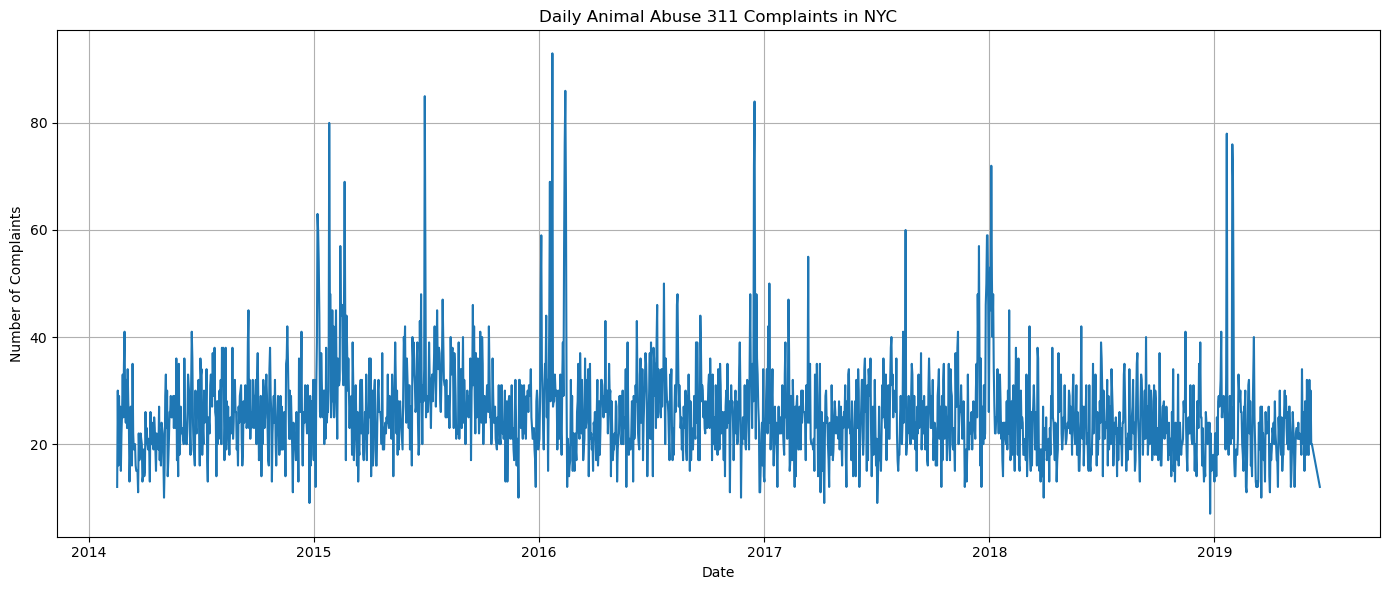

In [63]:
# Make sure 'created_date' is datetime type
df['created_date'] = pd.to_datetime(df['created_date'])

# Create a new column for just the date (without time)
df['date'] = df['created_date'].dt.date

# Group by date and count number of complaints
daily_trend = df.groupby('date').size()

# Plot the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
daily_trend.plot()
plt.title("Daily Animal Abuse 311 Complaints in NYC")
plt.xlabel("Date")
plt.ylabel("Number of Complaints")
plt.grid(True)
plt.tight_layout()
plt.show()


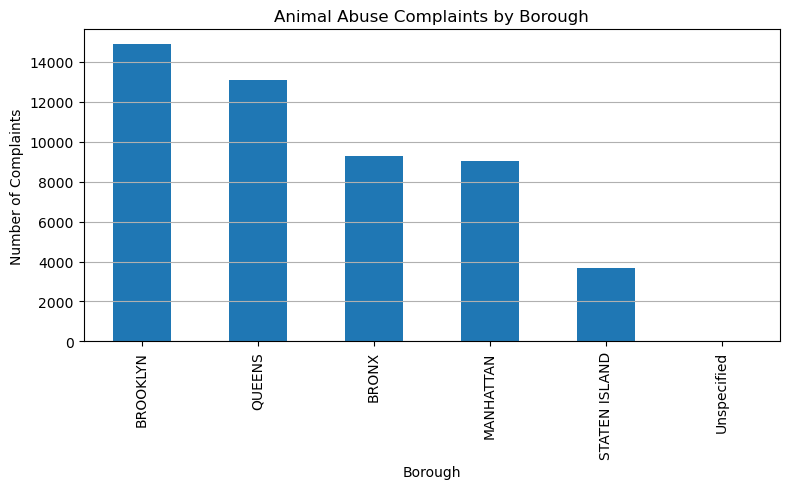

In [64]:
# Count complaints by borough
borough_counts = df['borough'].value_counts()

# Plot
borough_counts.plot(kind='bar', figsize=(8,5), title='Animal Abuse Complaints by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Complaints')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


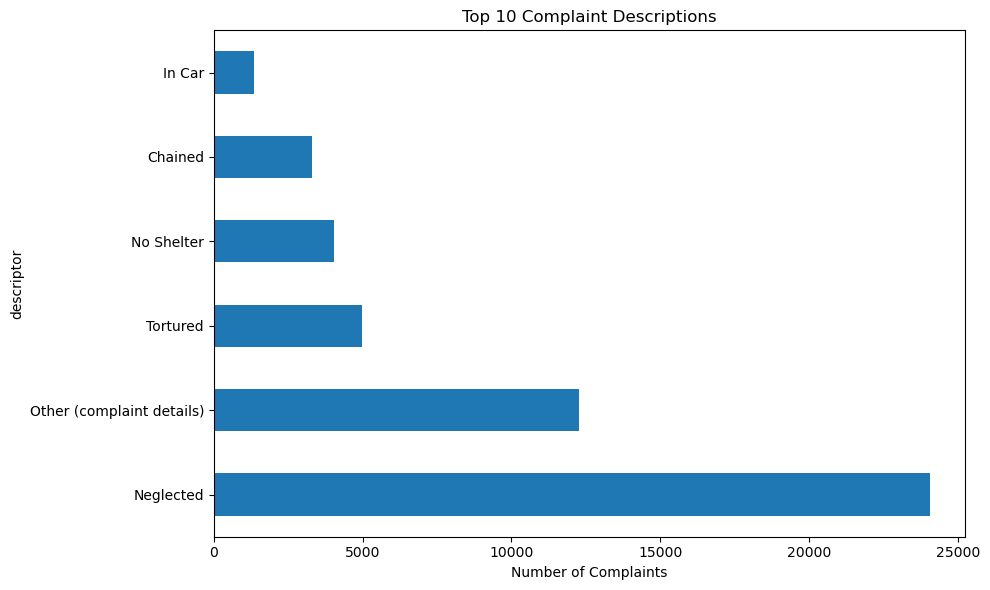

In [66]:
# Top 10 complaint descriptors
df['descriptor'].value_counts().head(10).plot(kind='barh', figsize=(10,6), title='Top 10 Complaint Descriptions')
plt.xlabel("Number of Complaints")
plt.tight_layout()
plt.show()


In [68]:
# Drop rows without location data
df_geo = df.dropna(subset=['latitude', 'longitude'])

# Confirm we have valid coordinates
df_geo[['latitude', 'longitude']].head()


,latitude,longitude
0,40.580723,-73.826713
1,40.701607,-73.916018
2,40.611022,-73.999744
3,40.701505,-74.012551
4,40.857166,-73.893647


In [71]:
!pip install folium


This heatmap shows concentrations of animal abuse complaints across NYC.


In [72]:
import folium
from folium.plugins import HeatMap

# Create a base map centered around NYC
map_center = [40.7128, -74.0060]
m = folium.Map(location=map_center, zoom_start=11)

# Filter valid coordinates
heat_data = df[['latitude', 'longitude']].dropna()

# Convert to list of [lat, lon] pairs
heat_points = heat_data.values.tolist()

# Add heatmap layer
HeatMap(heat_points, radius=10, blur=15, max_zoom=13).add_to(m)

# Display the map
m


🔵 Blue = Low density of animal abuse complaints  
🟢 Green = Medium density  
🟡 Yellow = High density  
🔴 Red = Very high density (hotspots)


In [74]:
nyc_map.save("animal_abuse_heatmap.html")


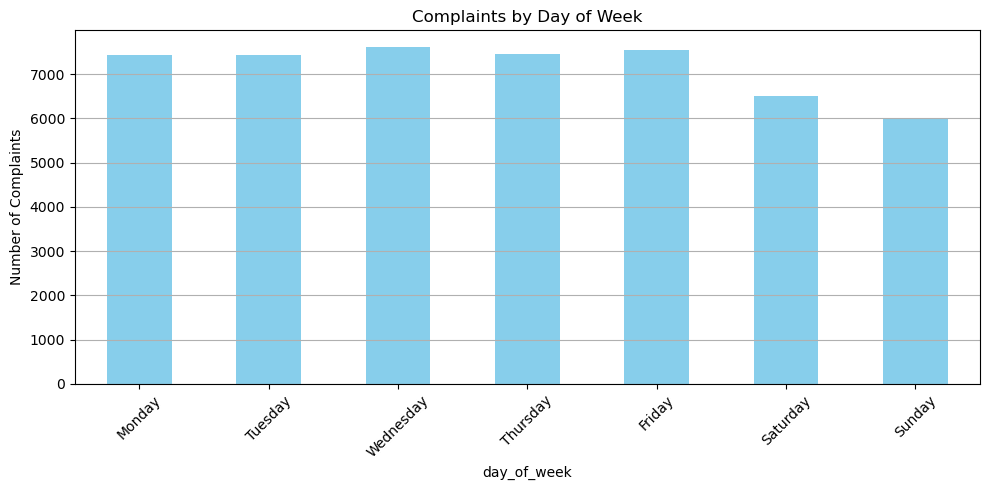

In [75]:
# Add day of week column
df['day_of_week'] = df['created_date'].dt.day_name()

# Count complaints by day of week
dow_counts = df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot
dow_counts.plot(kind='bar', figsize=(10,5), title='Complaints by Day of Week', color='skyblue')
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


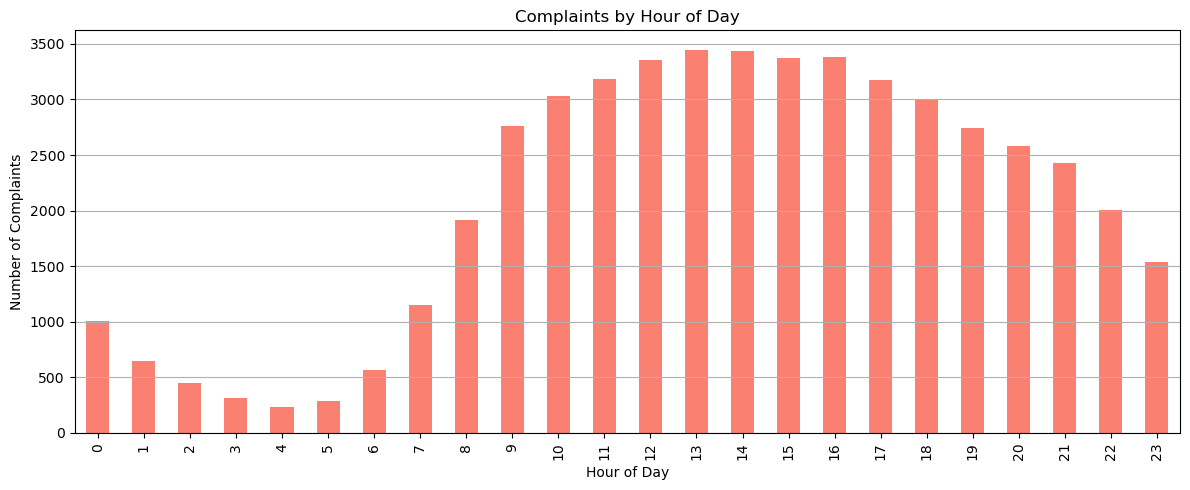

In [82]:
# Add hour column
df['hour'] = df['created_date'].dt.hour

# Count complaints by hour
hour_counts = df['hour'].value_counts().sort_index()

# Plot
hour_counts.plot(kind='bar', figsize=(12,5), title='Complaints by Hour of Day', color='salmon')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Complaints")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


- Most complaints come from Brooklyn.
- Complaints spike around 1 pm and on Wednesday.
- Certain areas show higher geographic concentration, possibly requiring targeted interventions.

Further research could include sentiment analysis of complaint descriptions or cross-referencing with shelter capacity and animal rescue response times.
